# **Many-to-many LSTM**

In [ ]:
!pip install muspy

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
import muspy
import matplotlib.pyplot as plt
import torch.nn.utils.rnn as rnn_utils

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 2), "GB")
    print("Memory Cached:", round(torch.cuda.memory_reserved(0)/1024**3, 2), "GB")

Using device: cuda
GPU Name: NVIDIA L4
Memory Allocated: 0.0 GB
Memory Cached: 0.0 GB


In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

The imports and the devices are ready, let's load the data. The dataset is exactly the same as the one used with the Many-to-many GRU model.

In [ ]:
metadata = pd.read_csv("/content/drive/MyDrive/Piano generation/Project/MAESTRO dataset/maestro-v3.0.0.csv")

In [ ]:
class MusicDataset(Dataset):
    def __init__(self, metadata, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.songs = []

        for file in metadata["midi_filename"]:
            file_path = os.path.join("/content/drive/MyDrive/Piano generation/Project/MAESTRO dataset/maestro-v3.0.0-midi/maestro-v3.0.0/", file)
            muspy_file = muspy.read(file_path)
            self.songs.append(muspy_file)

    def __len__(self):
        return len(self.songs)

    def __getitem__(self, idx):
        pianoroll_song = self.songs[idx].to_pianoroll_representation()
        pianoroll_song = torch.tensor(pianoroll_song, dtype=torch.float32)

        start_idx = random.randint(0, len(pianoroll_song) - 2 * self.seq_len)

        input_seq = pianoroll_song[start_idx:start_idx+self.seq_len]

        target = pianoroll_song[start_idx+(self.seq_len // 2) : start_idx+self.seq_len+(self.seq_len // 2)]

        return input_seq, target

In [ ]:
music_dataset_train = torch.load("/content/drive/MyDrive/Piano generation/Project/saved_data/datasets/train/music_dataset_train_many_to_many_muspy.pt", weights_only=False)
music_dataset_val = torch.load("/content/drive/MyDrive/Piano generation/Project/saved_data/datasets/validation/music_dataset_val_many_to_many_muspy.pt", weights_only=False)

Here, the setup is very similar to the Many-to-one situation. There is only one difference. Instead of the hidden states, now the linear leayer takes the model's output just like with the Many-to-many GRU network.

In [ ]:
class ManyToManyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(ManyToManyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)

        return out

In [ ]:
def collate_fn(batch):
    sequences, targets = zip(*batch)

    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)
    return sequences_padded, targets_padded

In [ ]:
music_dataloader_train = DataLoader(music_dataset_train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, collate_fn=collate_fn)
music_dataloader_val = DataLoader(music_dataset_val, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, collate_fn=collate_fn)

Again, the input size is 128, the hidden size is 256, the number of LSTM layers is 2 and the output size is 128.

In [ ]:
many_to_many_lstm = ManyToManyLSTM(128, 256, 128, 2).to(device)

optimizer = optim.AdamW(many_to_many_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

There is no difference in the training

In [ ]:
def train_many_to_many_lstm(model, optimizer, criterion, num_epochs, train_loss_history, val_loss_history, create_plot=True):
    model.train()

    scaler = GradScaler()

    for epoch in range(num_epochs):
        total_loss = 0.0

        for sequences, targets in tqdm(music_dataloader_train, f"Epoch {len(train_loss_history)}:"):
            sequences, targets = sequences.to(device), targets.to(device)

            optimizer.zero_grad()
            output = model(sequences)

            loss = criterion(output, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(music_dataloader_train)
        train_loss_history.append(avg_train_loss)
        print("Average Training Loss:", avg_train_loss)

        model.eval()
        val_loss = 0.0

        for sequences, targets in music_dataloader_val:
            sequences, targets = sequences.to(device), targets.to(device)

            with torch.no_grad():
                output = model(sequences)
                loss = criterion(output, targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(music_dataloader_val)
        val_loss_history.append(avg_val_loss)
        print("Average Validation Loss:", avg_val_loss)
        model.train()

    if create_plot:
        plt.plot(train_loss_history, label="Training loss")
        plt.plot(val_loss_history, label="Validation loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.legend()
        plt.show()
        plt.savefig(f"/content/drive/MyDrive/Piano generation/Project/saved_data/plots/many_to_many_lstm_loss_epoch_{len(train_loss_history)}_plot.png")

    return train_loss_history, val_loss_history

Let's again look at the first 20 epochs of the training:

<ipython-input-12-3c7cd0517392>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 0:: 100%|██████████| 31/31 [00:58<00:00,  1.88s/it]

Average Training Loss: 62.92280726278982


Average Validation Loss: 56.75346984863281


Epoch 1:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Training Loss: 61.23791233185799


Average Validation Loss: 61.45612564086914


Epoch 2:: 100%|██████████| 31/31 [00:52<00:00,  1.68s/it]

Average Training Loss: 60.09453361265121


Average Validation Loss: 49.718976974487305


Epoch 3:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Training Loss: 54.93750492219002


Average Validation Loss: 45.8404354095459


Epoch 4:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Training Loss: 52.78867364698841


Average Validation Loss: 52.07099151611328


Epoch 5:: 100%|██████████| 31/31 [00:52<00:00,  1.70s/it]

Average Training Loss: 53.89874476771201


Average Validation Loss: 57.61636657714844


Epoch 6:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Training Loss: 54.54130492671843


Average Validation Loss: 46.06180839538574


Epoch 7:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Training Loss: 53.02694617548296


Average Validation Loss: 44.37646331787109


Epoch 8:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Training Loss: 55.75296131257088


Average Validation Loss: 53.59428100585937


Epoch 9:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]

Average Training Loss: 48.15645193284558


Average Validation Loss: 46.23491287231445


Epoch 10:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Training Loss: 48.88613780852287


Average Validation Loss: 55.15819778442383


Epoch 11:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Training Loss: 50.419966420819684


Average Validation Loss: 48.06129150390625


Epoch 12:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Training Loss: 54.40886417511971


Average Validation Loss: 53.02503967285156


Epoch 13:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Training Loss: 50.89188114289315


Average Validation Loss: 58.15563125610352


Epoch 14:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Training Loss: 50.28343114545268


Average Validation Loss: 43.2472843170166


Epoch 15:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 47.310933359207645


Average Validation Loss: 43.96630210876465


Epoch 16:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Training Loss: 46.55898592548986


Average Validation Loss: 49.35839767456055


Epoch 17:: 100%|██████████| 31/31 [00:54<00:00,  1.74s/it]

Average Training Loss: 45.96487365230437


Average Validation Loss: 51.541263580322266


Epoch 18:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Training Loss: 46.89797869036275


Average Validation Loss: 50.08038864135742


Epoch 19:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Training Loss: 48.249608070619644


Average Validation Loss: 46.762105560302736


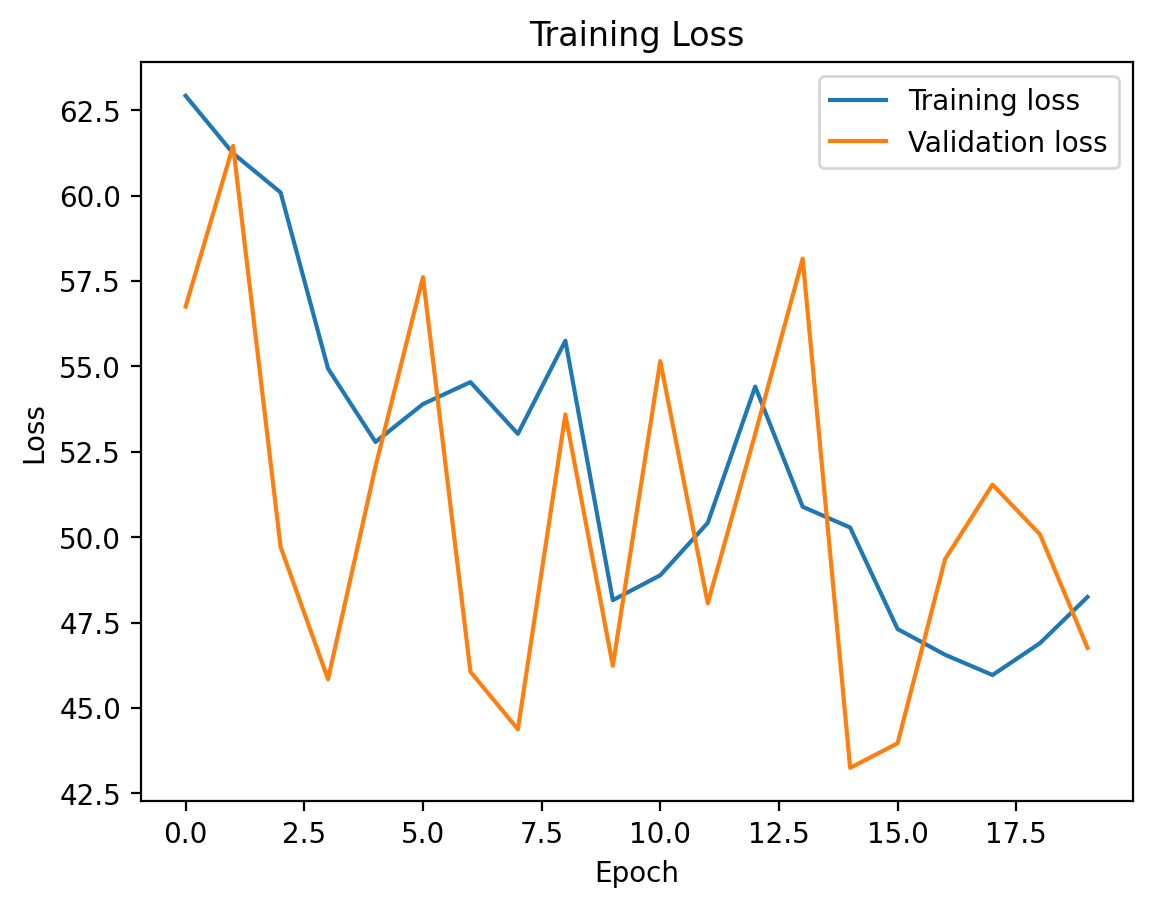

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_many_to_many_lstm(many_to_many_lstm, optimizer, criterion, 20, [], [], True)

There is somewhat of a downward trend, but it isn't very apparent. Let's look at the next 30 epochs:

<ipython-input-12-3c7cd0517392>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 0:: 100%|██████████| 31/31 [00:52<00:00,  1.69s/it]

Average Training Loss: 45.237671759820756


Average Validation Loss: 43.68010482788086


Epoch 1:: 100%|██████████| 31/31 [00:57<00:00,  1.84s/it]

Average Training Loss: 45.89316906467561


Average Validation Loss: 52.33932189941406


Epoch 2:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Training Loss: 44.20369049810594


Average Validation Loss: 38.51826210021973


Epoch 3:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Training Loss: 46.278026334701046


Average Validation Loss: 43.18238143920898


Epoch 4:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 47.31334710890247


Average Validation Loss: 41.795649719238284


Epoch 5:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Training Loss: 45.895416259765625


Average Validation Loss: 44.361959075927736


Epoch 6:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 44.884918274418


Average Validation Loss: 39.440983581542966


Epoch 7:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 44.35204435260065


Average Validation Loss: 47.230535888671874


Epoch 8:: 100%|██████████| 31/31 [00:52<00:00,  1.69s/it]

Average Training Loss: 46.2762083238171


Average Validation Loss: 46.374552154541014


Epoch 9:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Training Loss: 44.10643454520933


Average Validation Loss: 50.24683609008789


Epoch 10:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Training Loss: 44.98012536571872


Average Validation Loss: 47.17648200988769


Epoch 11:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Training Loss: 46.055039805750695


Average Validation Loss: 52.636087799072264


Epoch 12:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Training Loss: 42.20080474115187


Average Validation Loss: 42.46162567138672


Epoch 13:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Training Loss: 41.60909240476547


Average Validation Loss: 46.04218063354492


Epoch 14:: 100%|██████████| 31/31 [00:52<00:00,  1.68s/it]

Average Training Loss: 45.899873241301506


Average Validation Loss: 41.07709007263183


Epoch 15:: 100%|██████████| 31/31 [00:58<00:00,  1.87s/it]

Average Training Loss: 44.36647089066044


Average Validation Loss: 48.24505348205567


Epoch 16:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Training Loss: 45.171079143401116


Average Validation Loss: 37.64274024963379


Epoch 17:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 42.42316042992376


Average Validation Loss: 41.32467193603516


Epoch 18:: 100%|██████████| 31/31 [00:53<00:00,  1.71s/it]

Average Training Loss: 41.15597780289188


Average Validation Loss: 39.29101333618164


Epoch 19:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 43.87393176171087


Average Validation Loss: 40.95038261413574


Epoch 20:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Training Loss: 43.55916995386924


Average Validation Loss: 37.647953033447266


Epoch 21:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Training Loss: 40.462269075455204


Average Validation Loss: 36.42566070556641


Epoch 22:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Training Loss: 45.09824937389743


Average Validation Loss: 41.24960861206055


Epoch 23:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Training Loss: 40.22851679402013


Average Validation Loss: 44.66199264526367


Epoch 24:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Training Loss: 41.15349443497196


Average Validation Loss: 43.757817077636716


Epoch 25:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Training Loss: 42.05457299755466


Average Validation Loss: 40.31776504516601


Epoch 26:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Training Loss: 40.06873035430908


Average Validation Loss: 40.97909164428711


Epoch 27:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Training Loss: 44.15503569572203


Average Validation Loss: 34.456386947631835


Epoch 28:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Training Loss: 41.413235018330234


Average Validation Loss: 39.511067962646486


Epoch 29:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Training Loss: 42.2042663943383


Average Validation Loss: 38.848643112182614


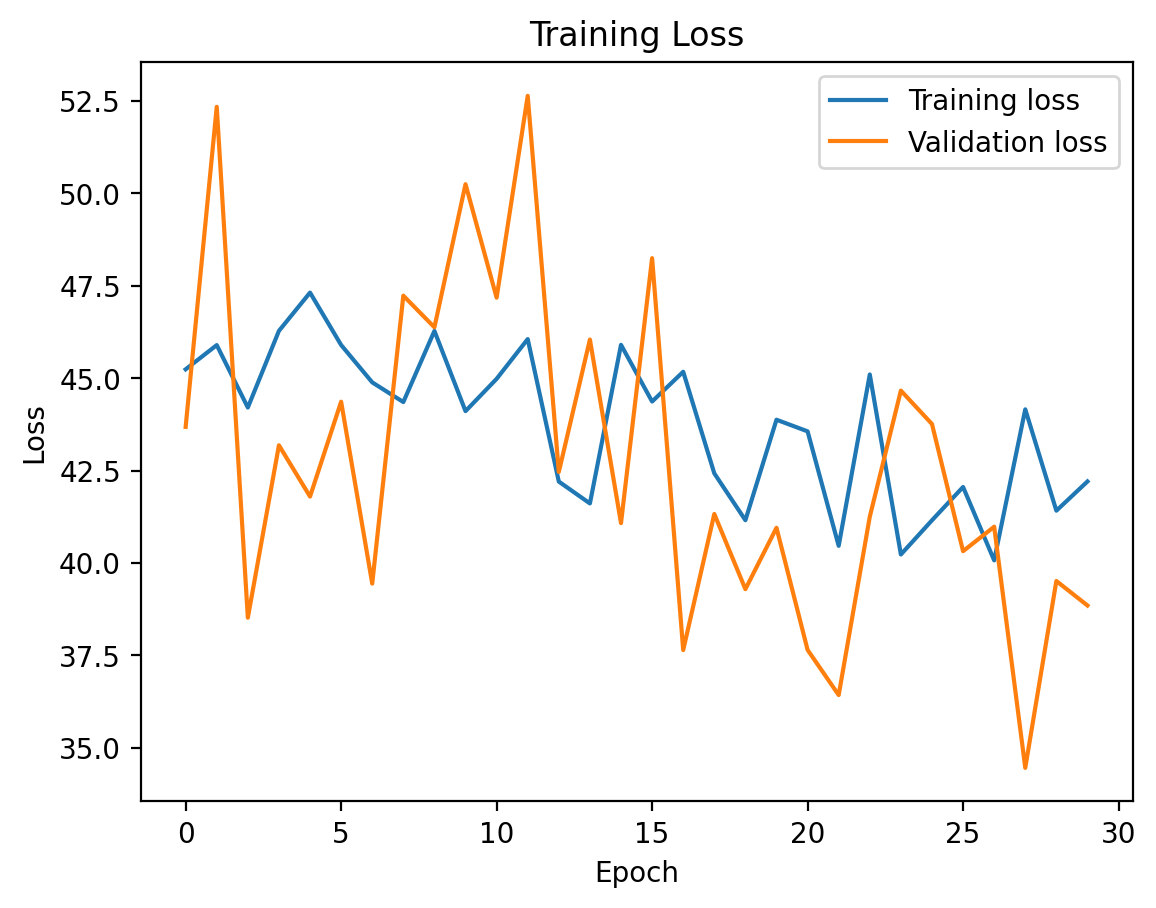

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_many_to_many_lstm(many_to_many_lstm, optimizer, criterion, 30, train_loss_history, val_loss_history, True)

Here it is clear, that the model stagnates so it's best to ditch Many-to-Many with an LSTM as well.